In [1]:

from dpm_preprocessing import DPMProprocessed
import torch
# from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments, RobertaConfig
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import f1_score
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Looking in indexes: https://mirrors.aliyun.com/pypi/simple


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

model_name = "microsoft/deberta-v2-xlarge"
model_path = f'./models5e6/pcl_{model_name}_finetuned/model/'
tokenizer_path = f'./models5e6/pcl_{model_name}_finetuned/tokenizer/'
MAX_SEQ_LEN = 256


In [3]:
from dpm_preprocessing import DPMProprocessed

dpm_pp = DPMProprocessed('.', 'task4_test.tsv')


train_df_path = 'traindf_backtrans.pickle'
val_df_path = 'valdf_backtrans.pickle'

train_df = pd.read_pickle(train_df_path)
val_df = pd.read_pickle(val_df_path)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}
      par_id      art_id     keyword country  \
0          1  @@24942188    hopeless      ph   
1          2  @@21968160     migrant      gh   
2          3  @@16584954   immigrant      ie   
3          4   @@7811231    disabled      nz   
4          5   @@1494111     refugee      ca   
...      ...         ...         ...     ...   
10464  10465  @@14297363       women      lk   
10465  10466  @@70091353  vulnerable      ph   
10466  10467  @@20282330     in-need      ng   
10467  10468  @@16753236    hopeless      in   
10468  10469  @@16779383    homeless      ie   

                                                    text  label orig_label  \
0      We are living in times of absolute insanity , ...      0          0   
1      In Libya today , there are countless number of...      0         

In [4]:
val_df_split_orig = [] 
for i in range(5):
    val_df_split_orig.append(val_df[val_df['orig_label'] == str(i)]['text'])

In [5]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

model.eval()
model.cpu()

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1536, padding_idx=0)
      (LayerNorm): LayerNorm((1536,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1536, out_features=1536, bias=True)
              (key_proj): Linear(in_features=1536, out_features=1536, bias=True)
              (value_proj): Linear(in_features=1536, out_features=1536, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1536, out_features=1536, bias=True)
              (LayerNorm): LayerNorm((1536,), eps=1e-07, elementwise_aff

In [6]:
def evaluate_df_item(text):
    with torch.no_grad():  
        encodings = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=MAX_SEQ_LEN)
        output = model(**encodings)
        logits = output.logits
        prob = nn.functional.softmax(logits)[:, 1]
        return prob.item()

In [7]:
print(len(val_df))
val_df['prob_pcl'] = val_df['text'].map(evaluate_df_item)

1047


/tmp/ipykernel_14807/3751858083.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = nn.functional.softmax(logits)[:, 1]


In [8]:
val_df.to_pickle('val_df_prob_pcl.pickle')

In [9]:
val_df_split_orig = [] 
for i in range(5):
    val_df_split_orig.append(val_df[val_df['orig_label'] == str(i)]['prob_pcl'])

[0.01658866228185835, 0.18068804588179027, 0.46519472676883805, 0.5036295687072931, 0.778287201171568]
[0.12326203253335281, 0.37882583652541324, 0.48192378145185183, 0.48192189207433733, 0.3927292466136566]


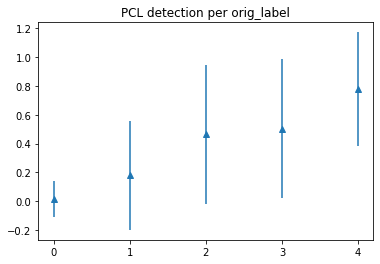

In [36]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5,3.5))
x = np.array([0, 1, 2, 3, 4])
y = [val_df_split_orig_i.mean() for val_df_split_orig_i in val_df_split_orig ] # Effectively y = x**2
#e = [np.std()])
e = [val_df_split_orig_i.std() for val_df_split_orig_i in val_df_split_orig ] 
plt.title('PCL detection per orig_label')
plt.xticks(np.arange(5)) 

plt.errorbar(x, y, e, linestyle='None', marker='^')
print(y)
print(e)

In [11]:
tag2id = {
				'Unbalanced_power_relations':0,
				'Shallow_solution':1,
				'Presupposition':2,
				'Authority_voice':3,
				'Metaphors':4,
				'Compassion':5,
				'The_poorer_the_merrier':6
				}
                

par_id_val = val_df['par_id'].tolist()

val_task2 = dpm_pp.train_task2_df.drop(dpm_pp.train_task2_df[dpm_pp.train_task2_df['par_id'].map(lambda id: (id not in par_id_val) )].index)

In [31]:
val_df_split_cat = []
for i in range(7):
    cat_df = val_task2[val_task2['label'].map(lambda label: bool(label[i]))]
    cat_df['prob_pcl'] = cat_df['par_id'].map(lambda pid: val_df[val_df['par_id'] == pid]['prob_pcl'].values)
    val_df_split_cat.append(cat_df)

/tmp/ipykernel_14807/2846639392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['prob_pcl'] = cat_df['par_id'].map(lambda pid: val_df[val_df['par_id'] == pid]['prob_pcl'].values)
/tmp/ipykernel_14807/2846639392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['prob_pcl'] = cat_df['par_id'].map(lambda pid: val_df[val_df['par_id'] == pid]['prob_pcl'].values)
/tmp/ipykernel_14807/2846639392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

<ErrorbarContainer object of 3 artists>

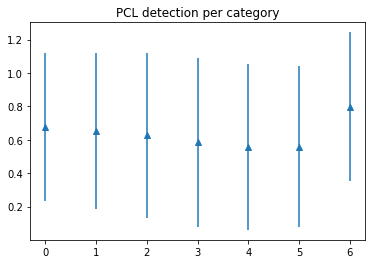

In [52]:
x = np.array([0, 1, 2, 3, 4, 5, 6])
plt.figure(figsize=(5,3.5))
y = [val_df_split_cat_i['prob_pcl'].mean() for val_df_split_cat_i in val_df_split_cat ] 
#e = [np.std()])
e = [val_df_split_cat_i['prob_pcl'].std() for val_df_split_cat_i in val_df_split_cat ] 
plt.title('PCL detection per category')
plt.errorbar(x, y, e, linestyle='None', marker='^')